In [12]:
refine_etype_prompt =  """Given a security report and (potentially) a list of entity types, please identify if there are more entity types needed, or the given entities needs correction.
Try to minimize the changes, that is, if adding or change an entity is not necessary, please do not do so.

We will create a knowledge graph based on a security report of an attack. The knowledge graph should record a connection of events happened during the attack. 
Your goal here: find a list of entity types that are necessary to build the knowledge graph.
When creating entities, you should think about entities that are related to the attack, not how we investigate the attack (like the kql queries).

You can add, change, or remove entity types following the format below.
############################
Add <|> Add <entity_type> <|> Reasoning: a certain entity should be in the knowledge graph but there is no entity type for it.
Change <|> Change <entity_type> to <new_entity_type> <|> Reasoning: change ... can cover ... and ...
Remove <|> Remove <entity_type> <|> Reasoning: why this entity type is not necessary."""

text = open("../t-andrewzhao/ransomware.txt").read()
entity_types = ["Attacker", "User", "Executable", "Script", "Payload", "File", "Link", "Email", "Endpoint"]

input_prompt = f"""############################
{text}
############################
Existing Entity Types: {entity_types}
############################
Your suggestions:"""

from myllm import call_autogen

response = await call_autogen(
    input = input_prompt,
    history= [{"role": "system", "content": refine_etype_prompt}]
)

In [ ]:
refine_etype_prompt =  """
We will create a knowledge graph based on a security report of an attack. The knowledge graph should record a connection of events happened during the attack. 
Your goal here: find a list of entity types that are necessary to build the knowledge graph.
When creating entities, you should think about entities that are related to the attack, not how we investigate the attack (like the kql queries).

Try to minimize the changes, that is, if adding or change an entity is not necessary, please do not do so.

Step 1: Extract all keywords that can be entities from the text.
Step 2: Identify the entity types for each keyword.
Step 3: Add, change, or remove entity types based on the following format.



You can add, change, or remove entity types following the format below.
############################
Keywords:
<keywords separated with ,>
############################
Keyword - entity type:
<keyword>: <entity_type>
############################
Suggestions:
Add <|> Add <entity_type> <|> Reasoning: a certain entity should be in the knowledge graph but there is no entity type for it.
Change <|> Change <entity_type> to <new_entity_type> <|> Reasoning: change ... can cover ... and ...
Remove <|> Remove <entity_type> <|> Reasoning: why this entity type is not necessary."""

text = open("../t-andrewzhao/ransomware.txt").read()
entity_types = ["Attacker", "User", "Executable", "Script", "Payload", "File", "Link", "Email", "Endpoint"]

input_prompt = f"""############################
{text}
############################
Existing Entity Types: {entity_types}
############################
Your suggestions:"""

from myllm import call_autogen

response = await call_autogen(

    
    input = input_prompt,
    history= [{"role": "system", "content": refine_etype_prompt}]
)

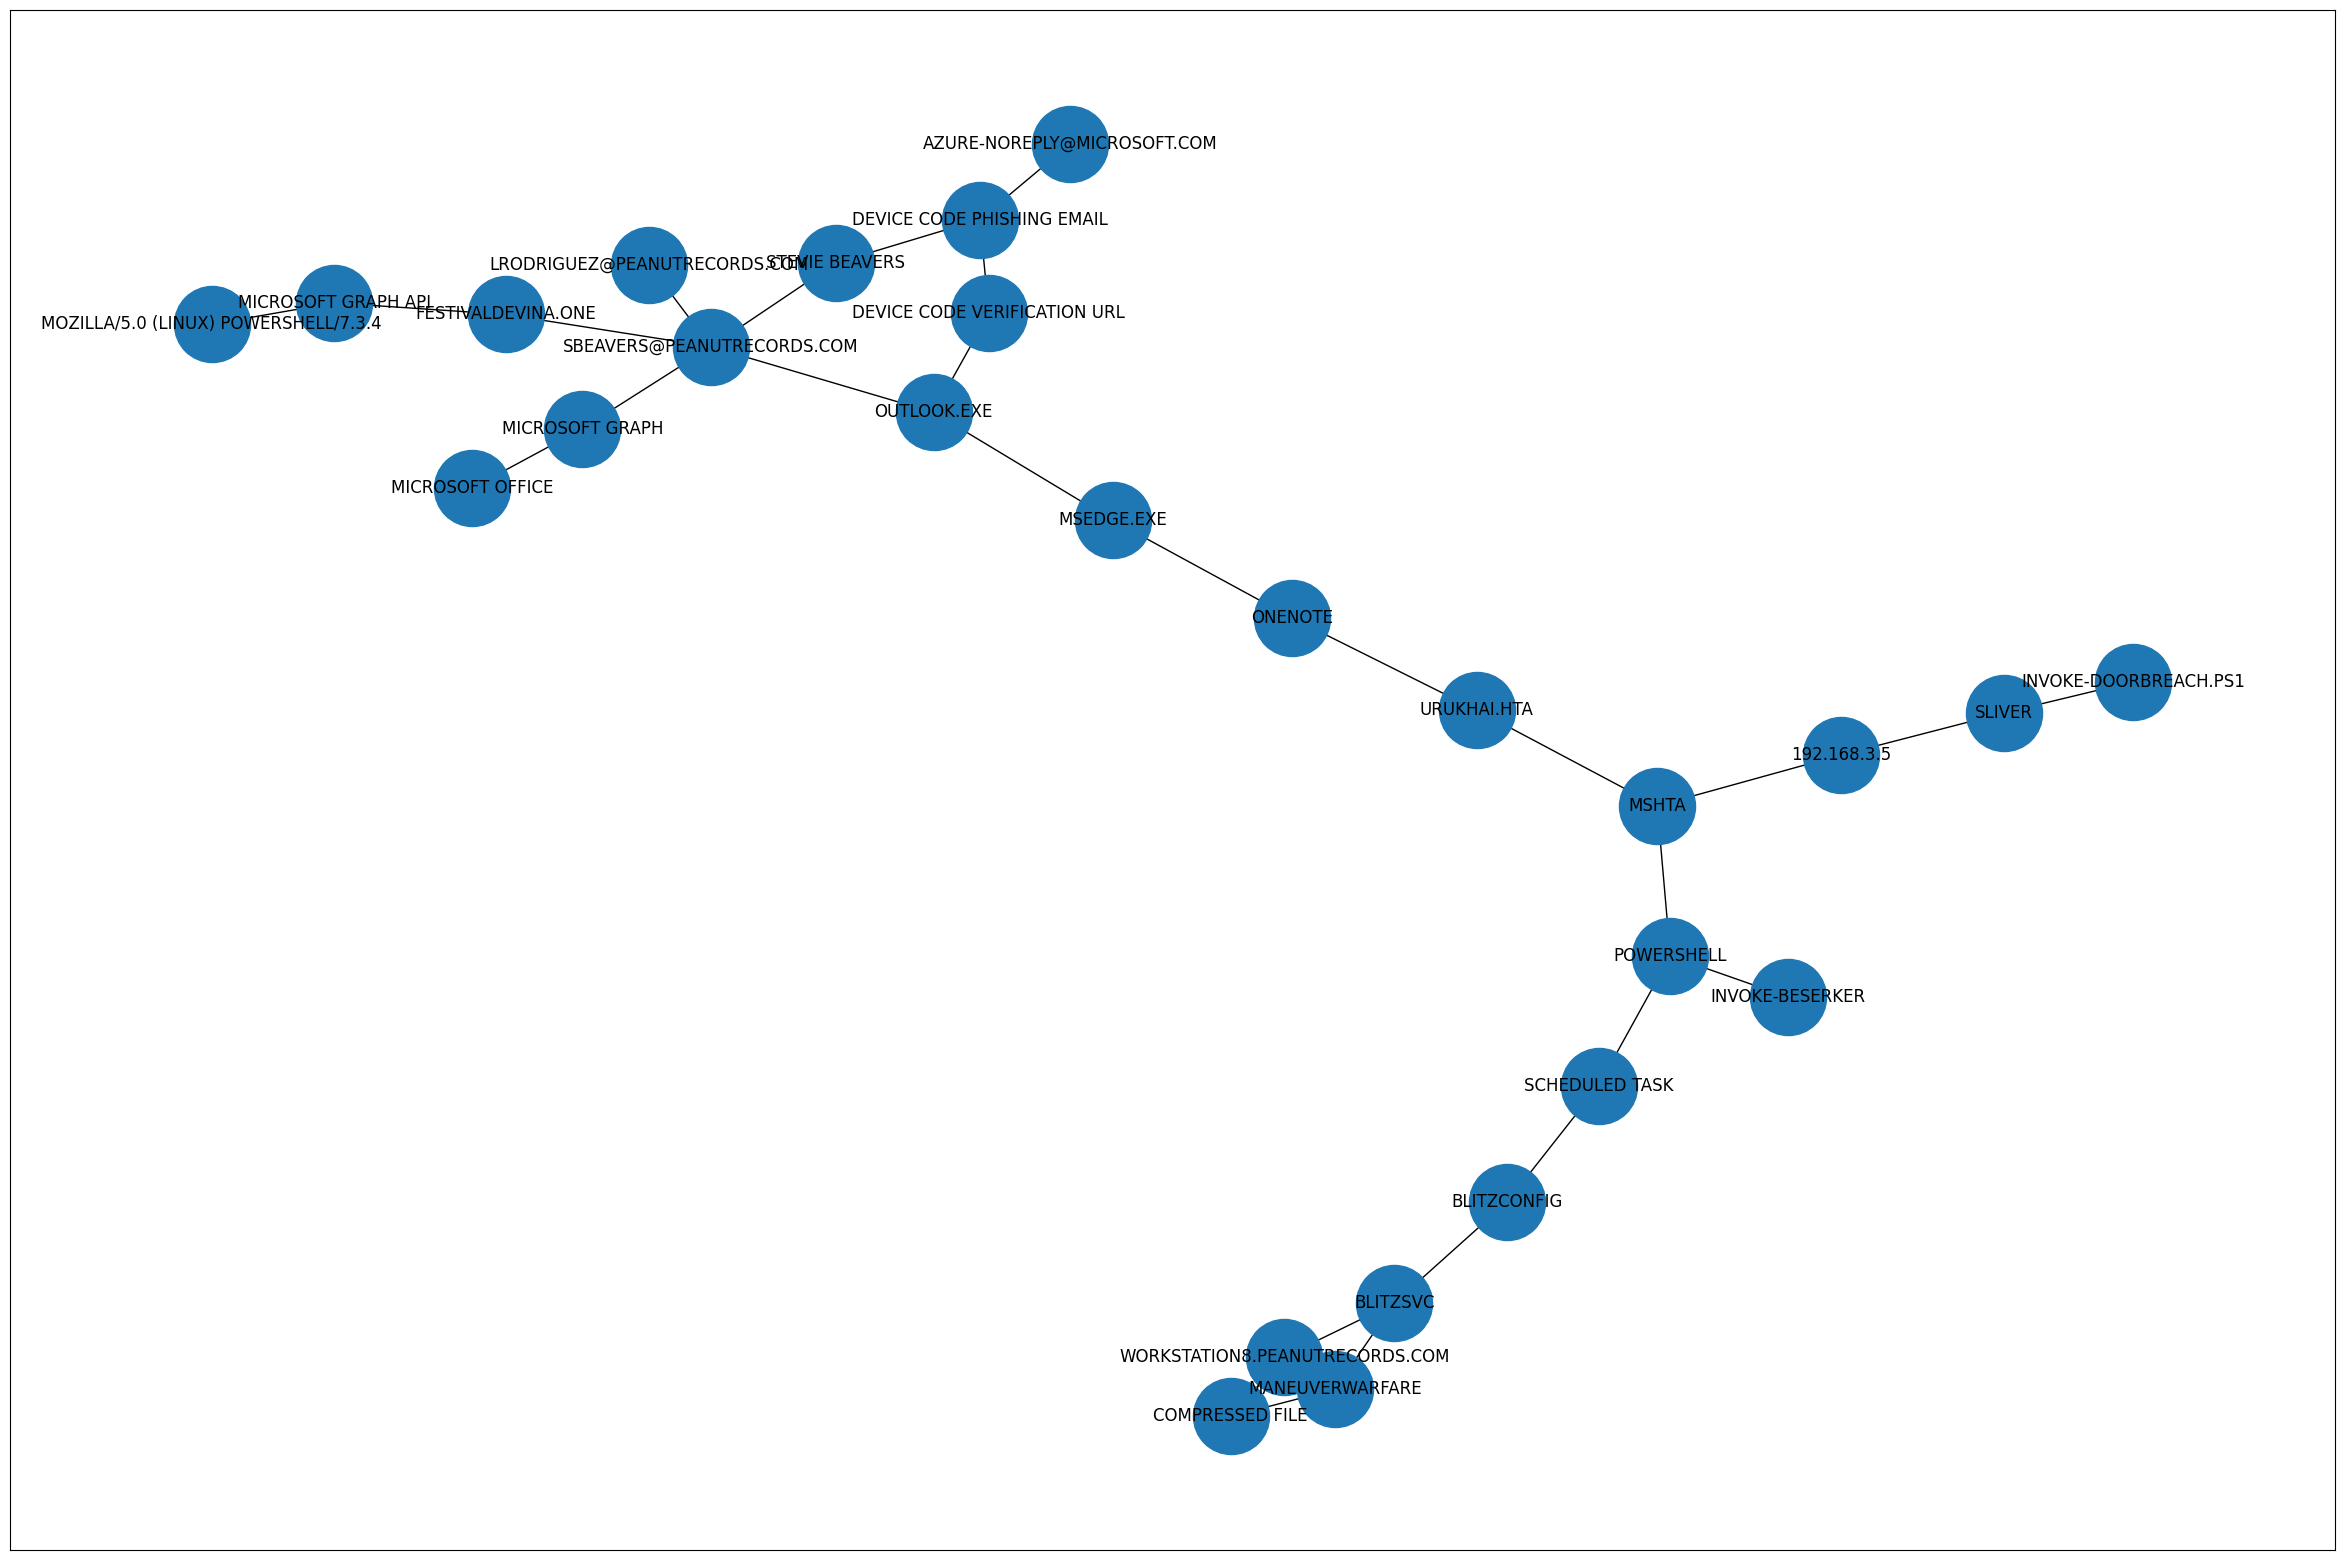

In [11]:
from extractor import GraphExtractor

import networkx as nx
import matplotlib.pyplot as plt

def plot_graph_with_attributes(G, node_attr_name=None, edge_attr_name=None, node_label_offset=(0.12, 0.05), fig_size=(10, 7)):
    pos = nx.spring_layout(G, seed=0)
    # pos = nx.bfs_layout(G, start="OUTLOOK.EXE")
    # pos = nx.kamada_kawai_layout(G)
    
    # Get edge attributes if provided
    edge_labels = nx.get_edge_attributes(G, edge_attr_name) if edge_attr_name else {}
    
    # Get node attributes if provided
    node_states = nx.get_node_attributes(G, node_attr_name) if node_attr_name else {}
    
    # Set node state positions if node attributes exist
    state_pos = {n: (x + node_label_offset[0], y + node_label_offset[1]) for n, (x, y) in pos.items()} if node_attr_name else {}
    
    # Increase the figure size
    plt.figure(figsize=fig_size)
    
    # Draw graph
    nx.draw_networkx(G, pos, node_size=3000)
    
    # Draw node state labels if node attributes exist
    if node_attr_name:
        nx.draw_networkx_labels(G, state_pos, labels=node_states, font_color='red')
    
    # Draw edge attributes if edge attributes exist
    if edge_attr_name:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, rotate=False)
    
    # Show plot
    plt.show()

extractor = GraphExtractor(
    existing_text=open("graph.txt").read(),
)

plot_graph_with_attributes(extractor._graph, edge_attr_name=None, node_label_offset=(0.15, 0.1), fig_size=(30, 20))



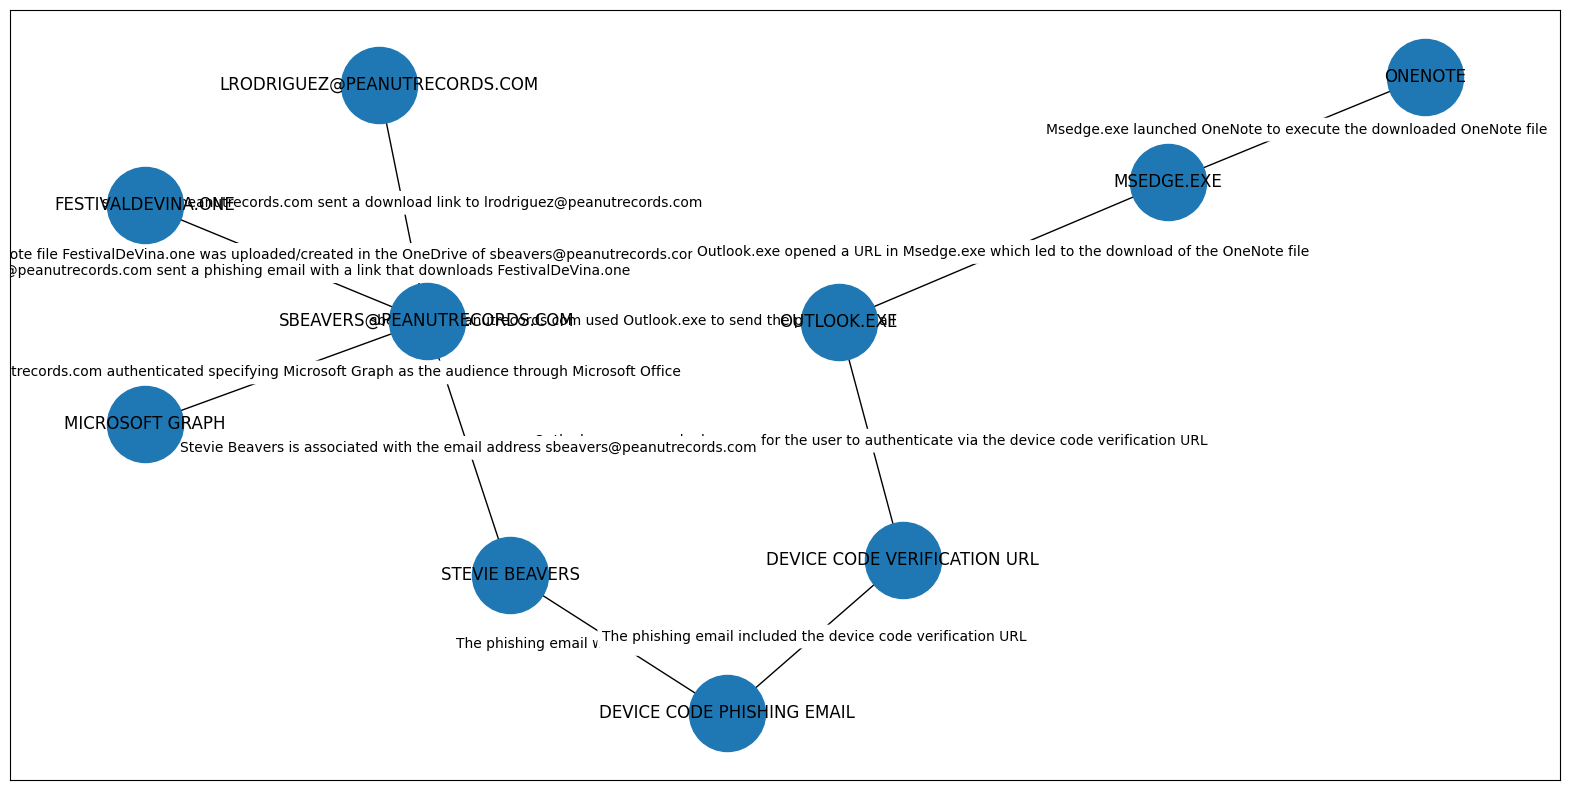

In [23]:
def plot_sub_graph(graph, node, depth=1):
    sub_graph = nx.ego_graph(graph, node, radius=depth)
    plot_graph_with_attributes(sub_graph, edge_attr_name="description", node_label_offset=(0.15, 0.1), fig_size=(20, 10))

plot_sub_graph(extractor._graph, "OUTLOOK.EXE", depth=2)

In [38]:
fewshot_qas = [
    {
        "context": "One of the first alerts in an incident report is related to a `ONENOTE.EXE` file executing some code. It seems to be potentially part of the threat actor's initial access tradecraft.",  
        "question":  "Can you find the relevant log(s) and analyze what happened?",
        "answer": "We can see that the `OneNote` document exported an HTA (HTML Application) file named `Urukhai.hta` which is then launched by `mshta` (Microsoft HTML Application Host).",
    },

     {
        "context": "We can see that a `OneNote` document exported an `HTA` (HTML Application) file named `Urukhai.hta` which is then launched by `mshta` (Microsoft HTML Application Host).",  
        "question": "What process was spawned from `mshta` and what did the process do?",
        "answer": "`PowerShell` was spawned. 1. Set the execution policy to unrestriced and hides the window, 2. download the `Invode-DoorBreach.ps1` script, 3. import the downloaded script as a module, 4. Executes the `invoke-DoorBreach` function.",
     },

    {
        "context": "We found a Silver command and control (C2) connection established.",
        "question": "How did the attacker establish the C2 connection?",
        "answer":"The attacker established the C2 connection using the `Invoke-DoorBreach` script.",
    },
    {
        "context": "We found an suspicious `Invoke-DoorBreach` script executed in the PowerShell logs.",
        "question": "Can you investigate with the evidence, and find what C2 (command and control) connection was used?",
        "answer":"The Sliver command and control (C2) connection was established.",
    },
    {
        "step": 4,
        "context": "We found a malicious OneNote file `FestivalDeVina.one` was uploaded / created in the `sbeavers@peanutrecords.com` OneDrive and a download link was sent to `lrodriguez@peanutrecords.com`.",
        "question": "Please explore operations performed under the Microsoft OneDrive for Business and on Stevie's sharepoint folder. Based on the exploration, can you determine what API was used to upload the malicious OneNote file?",
        "answer": "the Microsoft Graph (00000003-0000-0000-c000-000000000000) API was used to perform this operation.",
        "comments": "good"
    },
    {
        "step": 8,
        "context": "We found that malicious script executed on 'WORKSTATION8.peanutrecords.com' downloaded a compressed file to the Windows Temp folder using a function `Get-Artillery`. The contents extracted to the ProgramData directory: C:\\ProgramData\\PRGPOs",
        "question": "Can you check on events to see if there are any other malicious behaviors regarding this folder?",
        "answer": "The folder contains a backed-up Group Policy Object (GPO) named `ManeuverWarfare` that gets imported via the `Import-GPO` PowerShell Cmdlet to the Domain and attach to the `Workstations` AD organizational unit. This allows the threat actor to spread specific settings to all endpoints in the domain.",
        "comments": "good"
    },

]

from myllm import config_list
from autogen import OpenAIWrapper
import re
import networkx as nx

def run_qa_for_graph(extractor, node, depth):

    subgraph = nx.ego_graph(extractor._graph, node, radius=depth)

    nodes, edges = extractor.graph_to_text(subgraph)
    print(edges)
    return qa_from_graph(nodes+"\n##\n"+edges, fewshot_qas, n_questions=5)


def qa_from_graph(graph_str,
                  fewshot_qas,
                  n_questions=10):
    system_prompt = f"""You are a senior security analyst that will give questions answer pairs based on a investigation report for a simulated attack. These questions will be used to test the ability of a security agent.
The agent will be given a question, and a set of logs from the simulated attack. The agent will need to answer the question based on the logs.

The investigation report is converted in a knowledge graph below connecting the events together.
These questions should be designed to test the agent's ability to retrieve relevant information from tables, their knowledge in security, and their ability to analyze the data.

How to create questions:
- Context: You may give some background/context information, but do not give the answer to the question.
- Question: Given your question. Usually, the question should ask about a specific entity or relationship, it is best if the entity is a malicious entity or a relationship that is important to the attack.
- Answer: Provide the answer to the question.

IMPORTANT: The context+question will be given to agents to answer. Make sure the answer to the question is not in the context.

Please generate questions in this format: <i>. Context: <context> Question: <question>  Answer: <answer>

Example questions:
""" 
    qa_str = ""
    for i, qa in enumerate(fewshot_qas):
        qa_str += f"{i}. Context: {qa['context']} Question: {qa['question']} Answer: {qa['answer']}\n\n" #  Golden_Query: {qa['golden_query']}
    system_prompt += qa_str
    
    user_prompt = f"Please generate 1-{n_questions}(at most {n_questions}) based on the context length. Do not generate too many if they are asking about the same thing.\n\n <REFERENCE TEXT>\n{graph_str}</REFERENCE TEXT>\n\n1. "
    messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": user_prompt}]

    output = OpenAIWrapper(config_list=config_list, cache_seed=None).create(messages=messages).choices[0].message.content

    print(output)
    output = re.split(r"\n\d+\. ", output)
    output = output[1:]
    # put in json, remove Question: and Answer:
    
    dict_output = []
    for i in range(len(output)):
        try: 
            context, restpart = output[i].split("Question: ")
            question, restpart = restpart.split("Answer: ")
        except Exception as e:
            print(output[i])
            print("--------------")
            continue
        # answer, restpart = restpart.split("Golden_Query: ")
        # golden_query = restpart.strip()
        dict_output.append(
            {
                'context': context.replace("Context: ", "").strip(),
                'question': question.strip(),
                'answer': restpart.strip(),
                # 'golden_query': golden_query.strip()
            }
        )
    
    return dict_output
    

 # dirpath = f"outputs/{doc_id}"
        # os.makedirs(dirpath, exist_ok=True)
        # filepath = f"{dirpath}/questions.json"
        # with open(filepath, 'w') as f:
        #     json.dump(self.questions[doc_id], f, indent=4)
        # if verbose:
        #     print(f"Saved questions for {doc_id} to {filepath}")

        # prompt_filepath = f"{dirpath}/questions_prompt.json"
        # with open(prompt_filepath, "w") as file:
        #     json.dump(
        #         {
        #             "system_prompt": self.question_answer_system_prompt,
        #             "user_prompt": user_prompt,
        #         },
        #         file,
        #         indent=4
        #     )
        # if verbose:
        #     print(f"Saved question prompt to {prompt_filepath}")


In [39]:
from extractor import GraphExtractor
extractor = GraphExtractor(
    existing_text=open("graph.txt").read(),
)

dicoutput = run_qa_for_graph(extractor, "MSHTA", 2)

("entity"<|>INVOKE-BESERKER<|>EXECUTABLE<|>Invoke-Berserker is a function within a script that disables system recovery, deletes backups, encrypts files, and displays a ransom note)
##
("entity"<|>URUKHAI.HTA<|>FILE<|>Urukhai.hta is an HTA (HTML Application) file that was exported and executed by OneNote)
##
("entity"<|>MSHTA<|>EXECUTABLE<|>Mshta (Microsoft HTML Application Host) is an application used to execute HTA files, which was involved in executing the Urukhai.hta file in this incident)
##
("entity"<|>192.168.3.5<|>ENDPOINT<|>This IP address is associated with a remote session initiated by mshta and is used for outbound connections, identified as the C2 setup for this incident)
##
("entity"<|>SLIVER<|>PAYLOAD<|>Sliver is a payload that was detected as being executed in this incident)
##
("entity"<|>ONENOTE<|>EXECUTABLE<|>OneNote is a Microsoft application used for note-taking)
##
("entity"<|>POWERSHELL<|>SCRIPT<|>PowerShell is a scripting language and command-line shell, which w

In [40]:
dicoutput

[{'context': 'We found evidence indicating that `Mshta` launched `PowerShell` which potentially downloaded and executed additional scripts in memory.',
  'question': 'What specific function within the downloaded script executed by PowerShell could disable system recovery and encrypt files?',
  'answer': 'The `Invoke-Berserker` function within the script executed by PowerShell could disable system recovery and encrypt files.'},
 {'context': 'The IP address `192.168.3.5` was identified as having initiated a remote session from `mshta`, indicating an outbound connection to a C2 server.',
  'question': 'What was the payload detected in this incident that interacted with the endpoint at IP address `192.168.3.5`?',
  'answer': 'The Sliver payload was detected in this incident and interacted with the endpoint at IP address `192.168.3.5`.'},
 {'context': 'An HTA file named `Urukhai.hta` was executed by OneNote and subsequently launched by Mshta. This led to the PowerShell process being spawned

In [1]:

###################### 
texts = [
open("../t-andrewzhao/ransomware.txt").read()

]
texts = []
n=5
for i in range(n,n+1): # 11
    texts.append(open(f"../secbench/blitz/{i}.txt").read())
    
a = await extractor(
    texts=texts,
    prompt_variables={
        "entity_types": ["Attacker", "User", "Executable", "Script", "Payload", "File", "Link", "Email", "Endpoint", "API"],
        "tuple_delimiter": None,
        "record_delimiter": None,
        "completion_delimiter": None,
    },
)


print(a)

NameError: name 'extractor' is not defined

("entity"<|>SLIVER<|>PAYLOAD<|>Sliver is a payload that was detected as being executed in this incident)
##
("entity"<|>INVOKE-DOORBREACH.PS1<|>SCRIPT<|>Invoke-DoorBreach.ps1 is a PowerShell script that was executed in this incident)
##
("entity"<|>ONENOTE<|>EXECUTABLE<|>OneNote is a Microsoft application used for note-taking)
##
("entity"<|>URUKHAI.HTA<|>FILE<|>Urukhai.hta is an HTA (HTML Application) file that was exported and executed by OneNote)
##
("entity"<|>MSHTA<|>EXECUTABLE<|>Mshta (Microsoft HTML Application Host) is an application used to execute HTA files, which was involved in executing the Urukhai.hta file in this incident)
##
("entity"<|>POWERSHELL<|>SCRIPT<|>PowerShell is a scripting language and command-line shell, which was spawned by mshta to potentially download and execute an additional script in memory)
##
("entity"<|>192.168.3.5<|>ENDPOINT<|>This IP address is associated with a remote session initiated by mshta and is used for outbound connections, identified as 

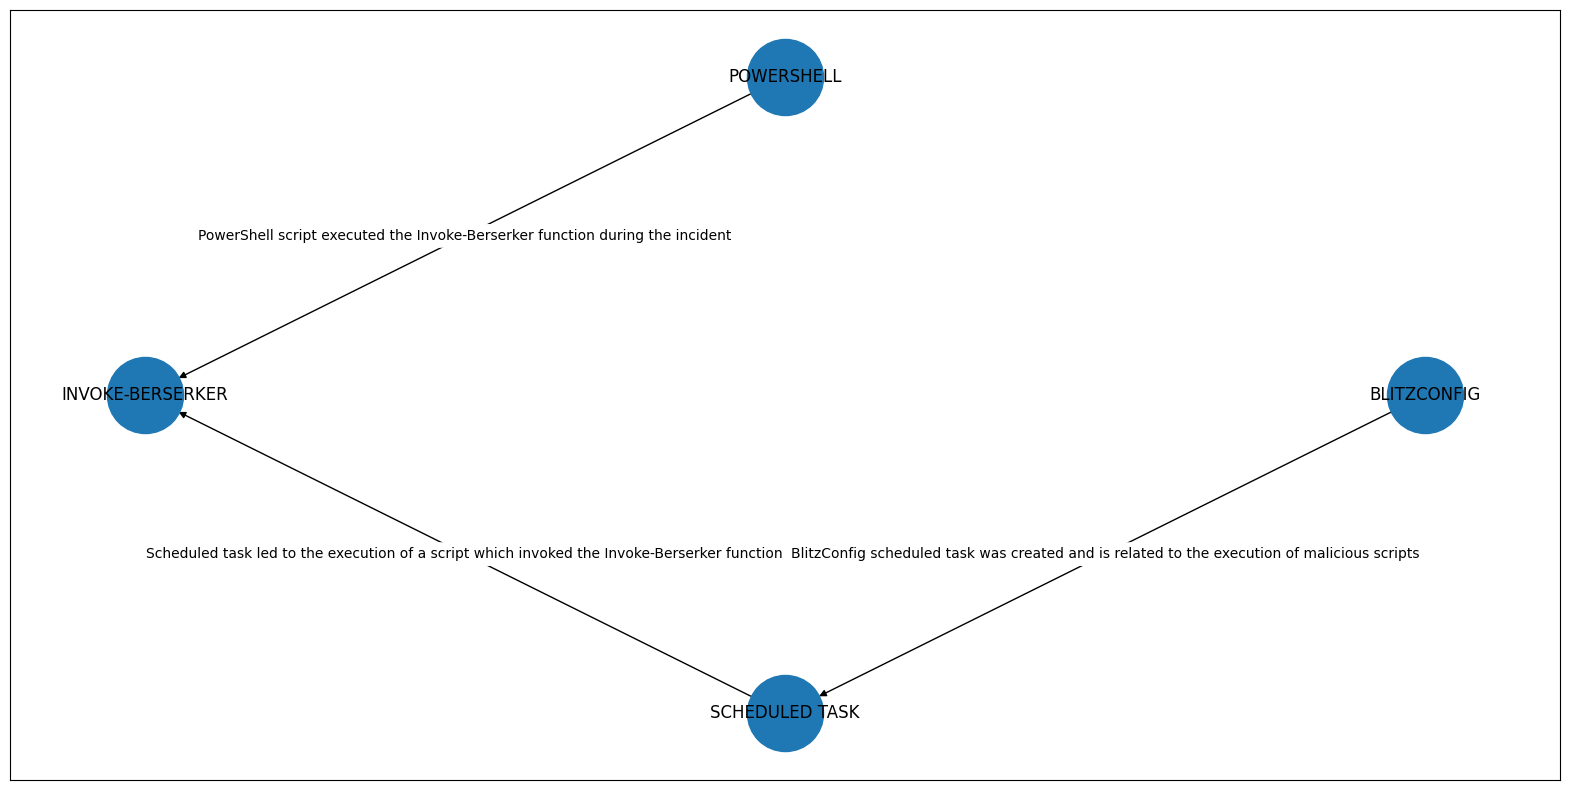

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph_with_attributes(G, node_attr_name=None, edge_attr_name=None, node_label_offset=(0.12, 0.05), fig_size=(10, 7)):
    pos = nx.spring_layout(G, seed=0)
    pos = nx.circular_layout(G)
        # pos = nx.bfs_layout(G, start="OUTLOOK")

    # pos = nx.kamada_kawai_layout(G)
    
    # Get edge attributes if provided
    edge_labels = nx.get_edge_attributes(G, edge_attr_name) if edge_attr_name else {}
    
    # Get node attributes if provided
    node_states = nx.get_node_attributes(G, node_attr_name) if node_attr_name else {}
    
    # Set node state positions if node attributes exist
    state_pos = {n: (x + node_label_offset[0], y + node_label_offset[1]) for n, (x, y) in pos.items()} if node_attr_name else {}
    
    # Increase the figure size
    plt.figure(figsize=fig_size)
    
    # Draw graph
    nx.draw_networkx(G, pos, node_size=3000)
    
    # Draw node state labels if node attributes exist
    if node_attr_name:
        nx.draw_networkx_labels(G, state_pos, labels=node_states, font_color='red')
    
    # Draw edge attributes if edge attributes exist
    if edge_attr_name:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, rotate=False)
    
    # Show plot
    plt.show()
    
prompt_variables={
    "entity_types": ["User", "Executable", "Payload", "File", "Email", "Endpoint", "API"],
    "tuple_delimiter": None,
    "record_delimiter": None,
    "completion_delimiter": None,
}

texts = []
n=10
for i in range(n,n+1): # 11
    texts.append(open(f"../secbench/blitz/{i}.txt").read())

from extractor import GraphExtractor
extractor = GraphExtractor(
    existing_text=open("graph.txt").read(),
)

for doc_index, text in enumerate(texts):
    entity_text = extractor._graph_to_text(extractor._graph)
    prompt_variables["previous_entities"] = entity_text[0]
    result = await extractor.process_single_doc(text, prompt_variables)
    if result is None:
        continue
    # print(result)
    prompt_variables = extractor.process_var(prompt_variables)
    extractor._graph = await extractor._process_results(
        results={doc_index: result},
        tuple_delimiter=prompt_variables.get(extractor._tuple_delimiter_key),
        record_delimiter=prompt_variables.get(extractor._record_delimiter_key),
        graph=nx.DiGraph(),
    )

    plot_graph_with_attributes(extractor._graph, edge_attr_name="description", node_label_offset=(0.15, 0.1), fig_size=(20, 10))


In [4]:
extractor._graph["MICROSOFT GRAPH"]

KeyError: 'MICROSOFT GRAPH'

In [2]:
texts = []
for i in range(3,4): # 11
    texts.append(open(f"../secbench/blitz/{i}.txt").read())
print(texts[0])


### 03 - Initial Access

Something that is not clear yet is how the `OneNote` file made it to the endpoint where the C2 connections was established.

#### OneNote File Download

Based on the parent process of `OneNote`, we can see that 
it was launched by `msedge.exe` and the `OneNote` file involved was one from the `Downloads` folder: `C:\Users\lrodriguez\Downloads\FestivalDeVina.one`. We can then infer that the file was downloaded potentially from a link and executed directly from the browser.

![](images/17-Investigation-InitialAccess-OneNoteFile-Creator.png)

If we expand on the details of the file, we can see `Mark of the Web` information which tells us the URL used to download the file

![](images/18-Investigation-InitialAccess-OneNoteFile-MOW.png)

![](images/19-Investigation-InitialAccess-OneNoteFile-MOW.png)

We can then run the following query to check what process launched the browser (`msedge`) to open that specific URL and download the `OneNote` file.

```
let url = "defe

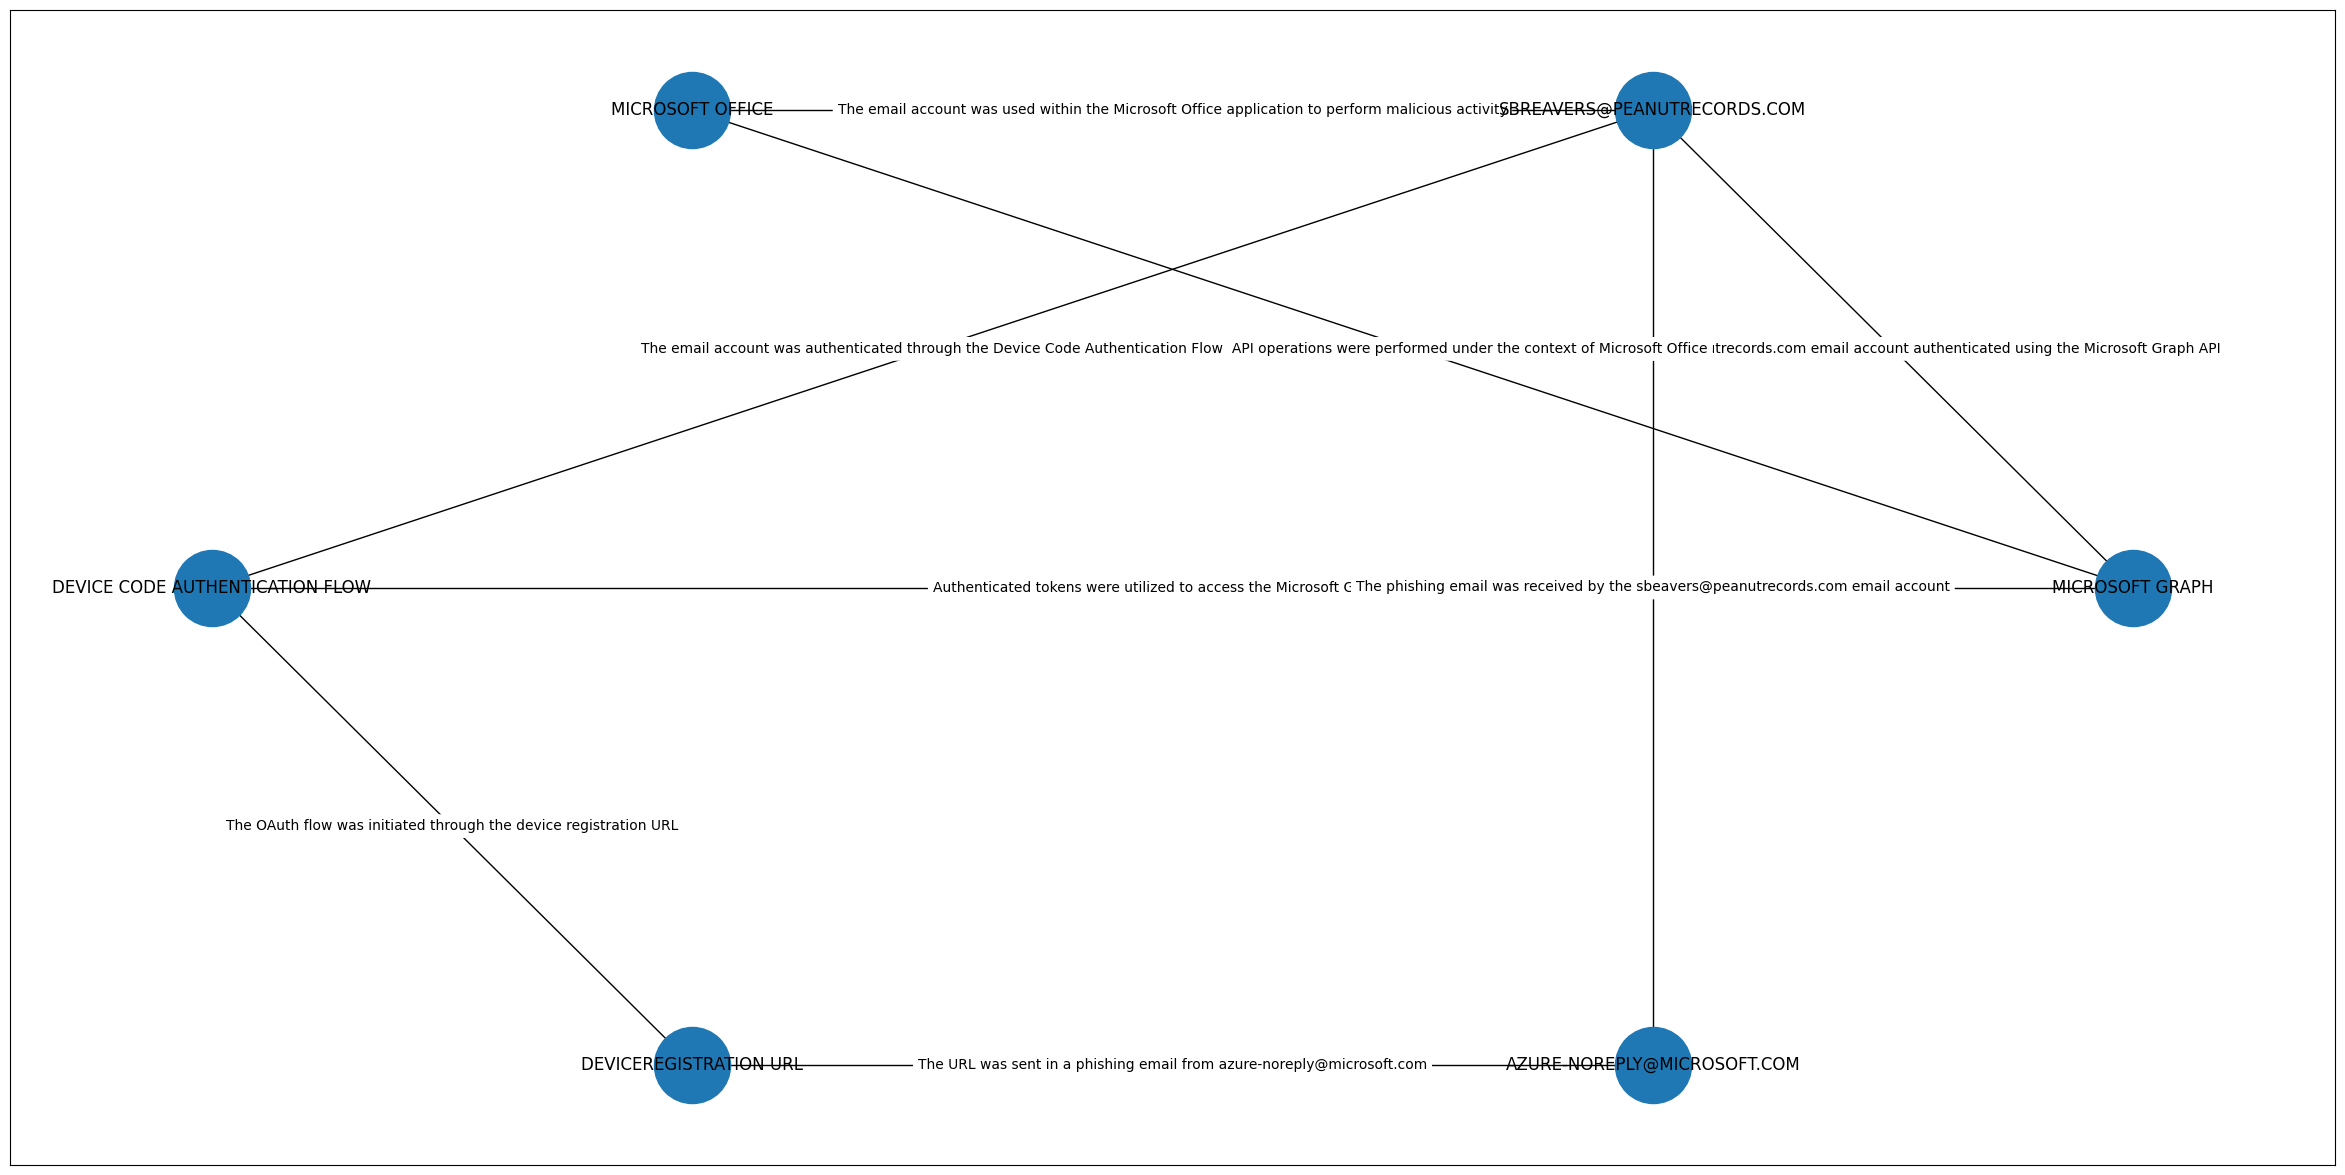

In [4]:
plot_graph_with_attributes(a.output, edge_attr_name="description", node_label_offset=(0.15, 0.1), fig_size=(30, 15))


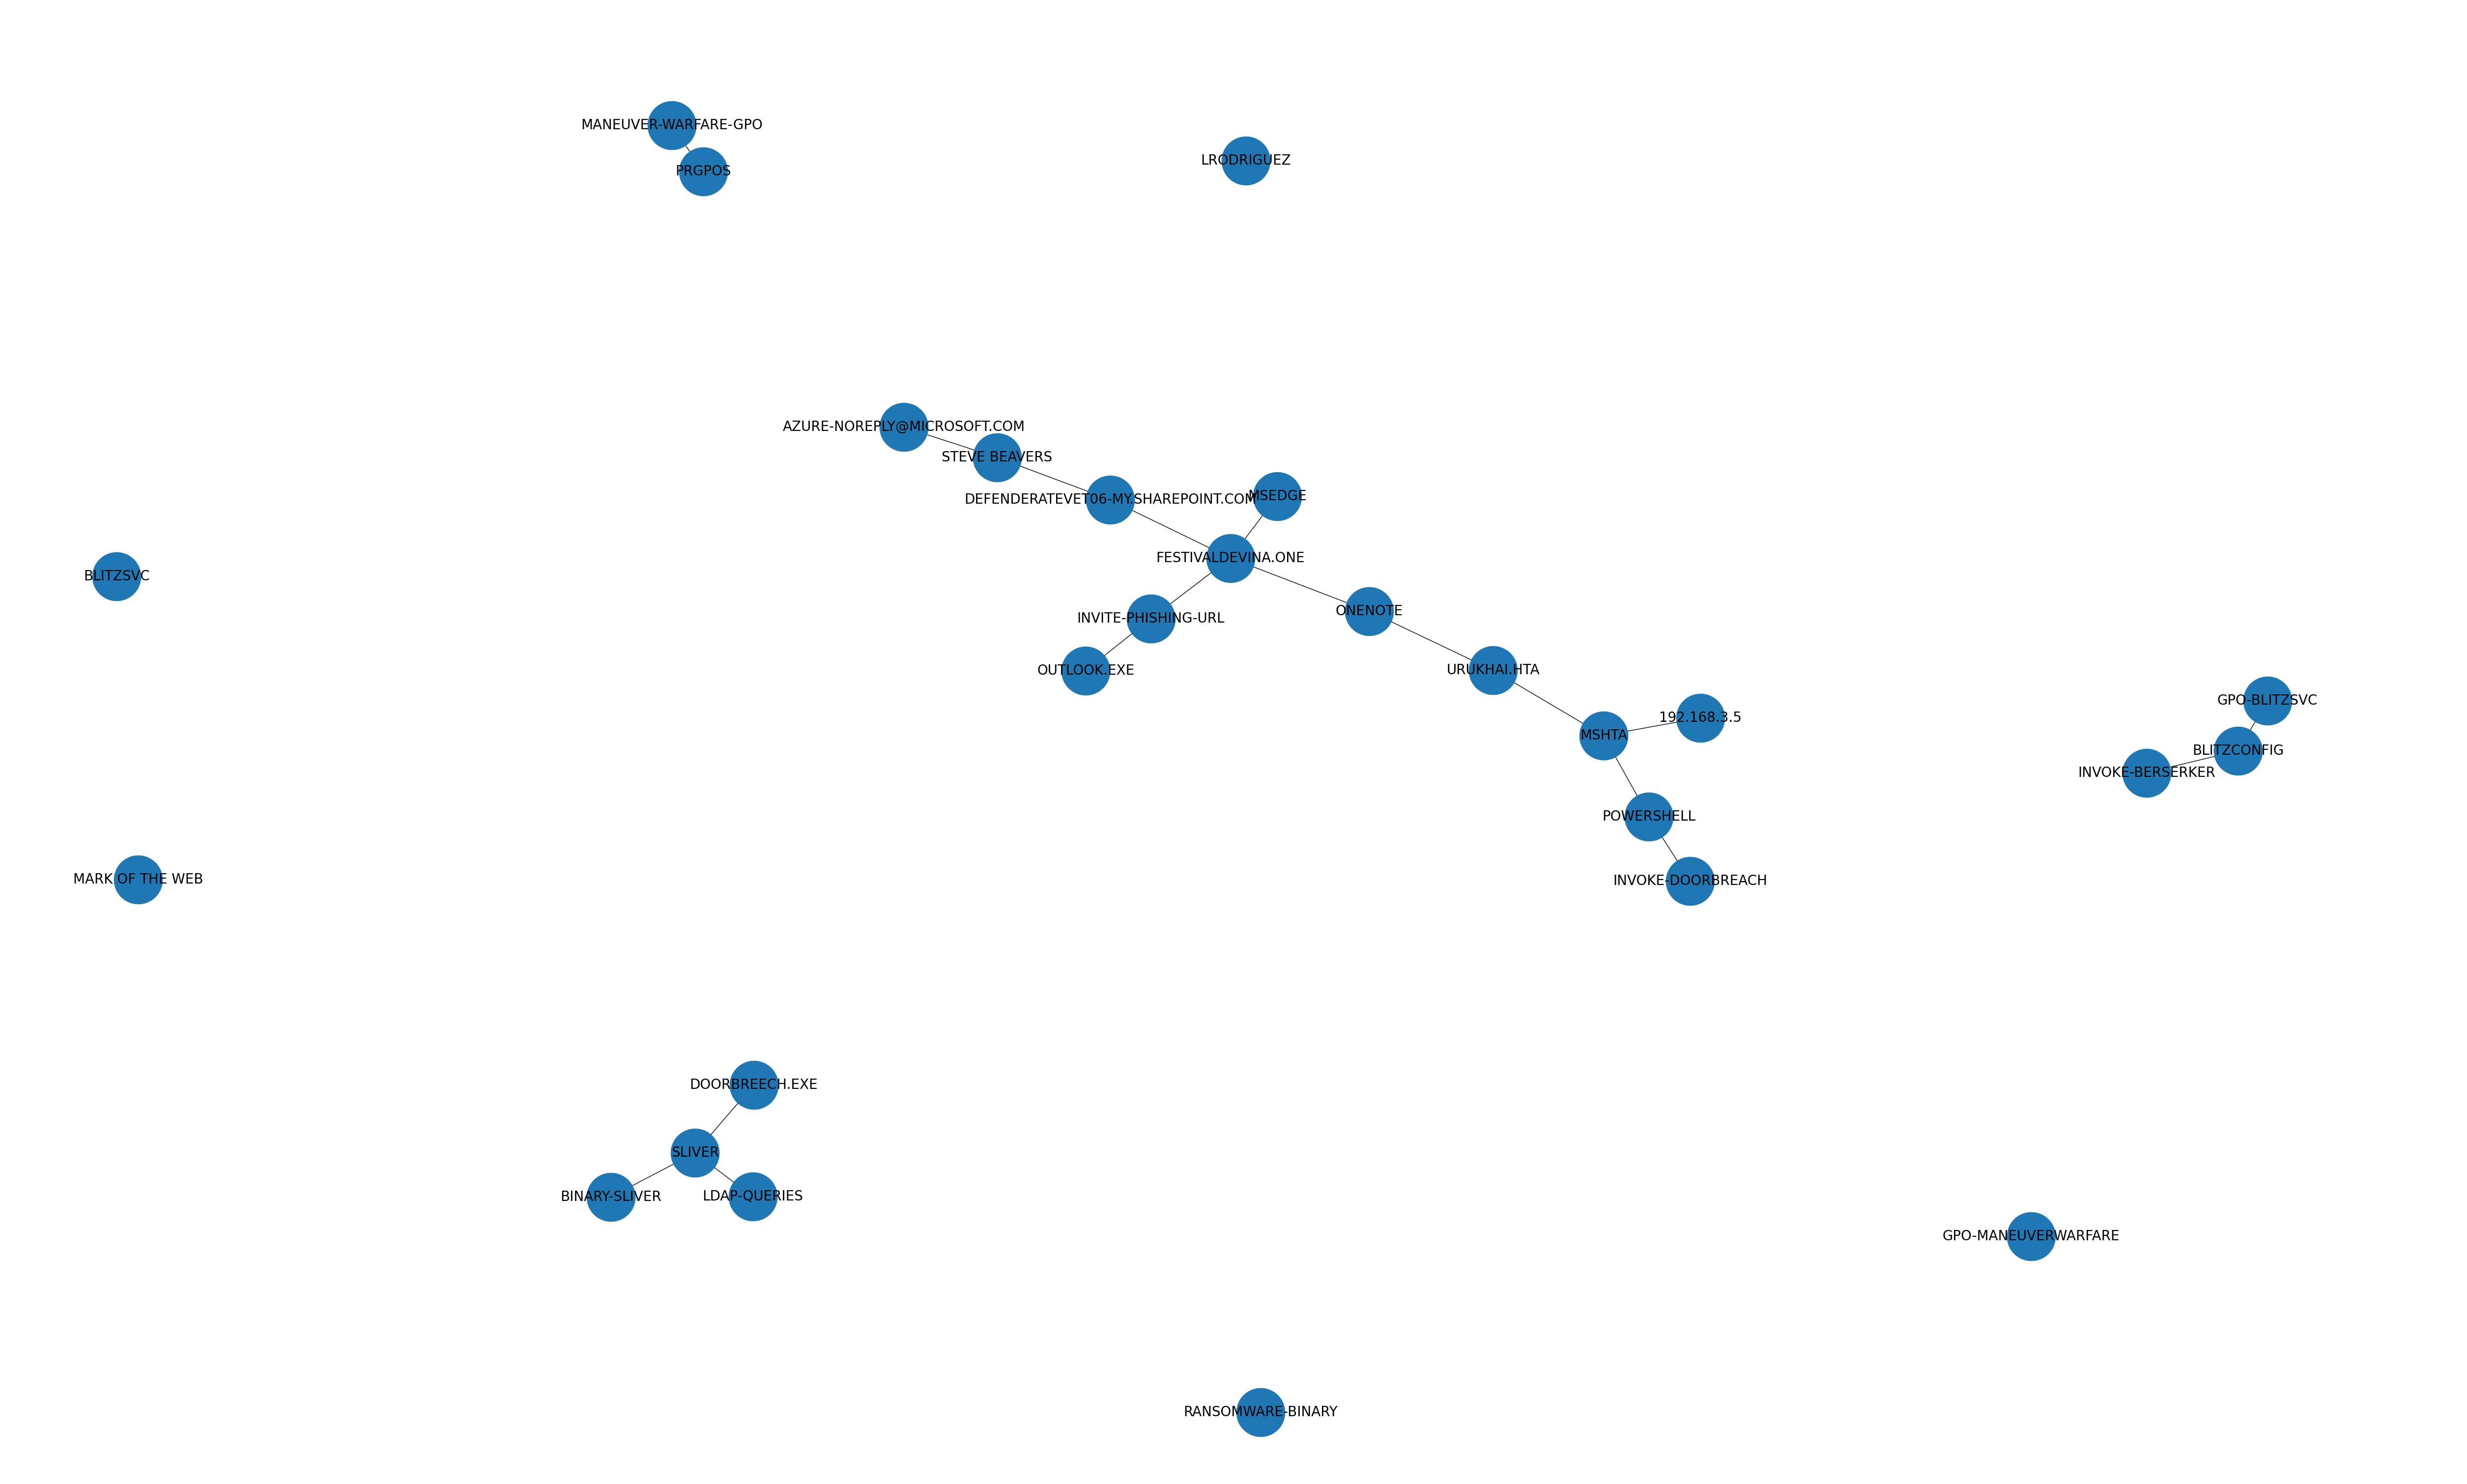

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize = (50, 30))

import networkx as nx
nx.draw(a.output, with_labels = True, node_size = 5000, font_size = 20)
plt.show()

In [17]:
a.output.adj

AdjacencyView({'URUKHAI.HTA': {'MSHTA': {'weight': 1.0, 'description': 'The HTA file Urukhai.hta was launched by MSHTA', 'source_id': '0'}}, 'MSHTA': {'URUKHAI.HTA': {'weight': 1.0, 'description': 'The HTA file Urukhai.hta was launched by MSHTA', 'source_id': '0'}, 'POWERSHELL': {'weight': 1.0, 'description': 'MSHTA spawned PowerShell', 'source_id': '0'}, '192.168.3.5': {'weight': 1.0, 'description': 'MSHTA established a remote session with the IP address 192.168.3.5', 'source_id': '0'}}, 'POWERSHELL': {'MSHTA': {'weight': 1.0, 'description': 'MSHTA spawned PowerShell', 'source_id': '0'}, '192.168.3.5': {'weight': 1.0, 'description': 'PowerShell script downloaded another script from the remote IP address 192.168.3.5 and executed it', 'source_id': '0'}}, '192.168.3.5': {'MSHTA': {'weight': 1.0, 'description': 'MSHTA established a remote session with the IP address 192.168.3.5', 'source_id': '0'}, 'POWERSHELL': {'weight': 1.0, 'description': 'PowerShell script downloaded another script f

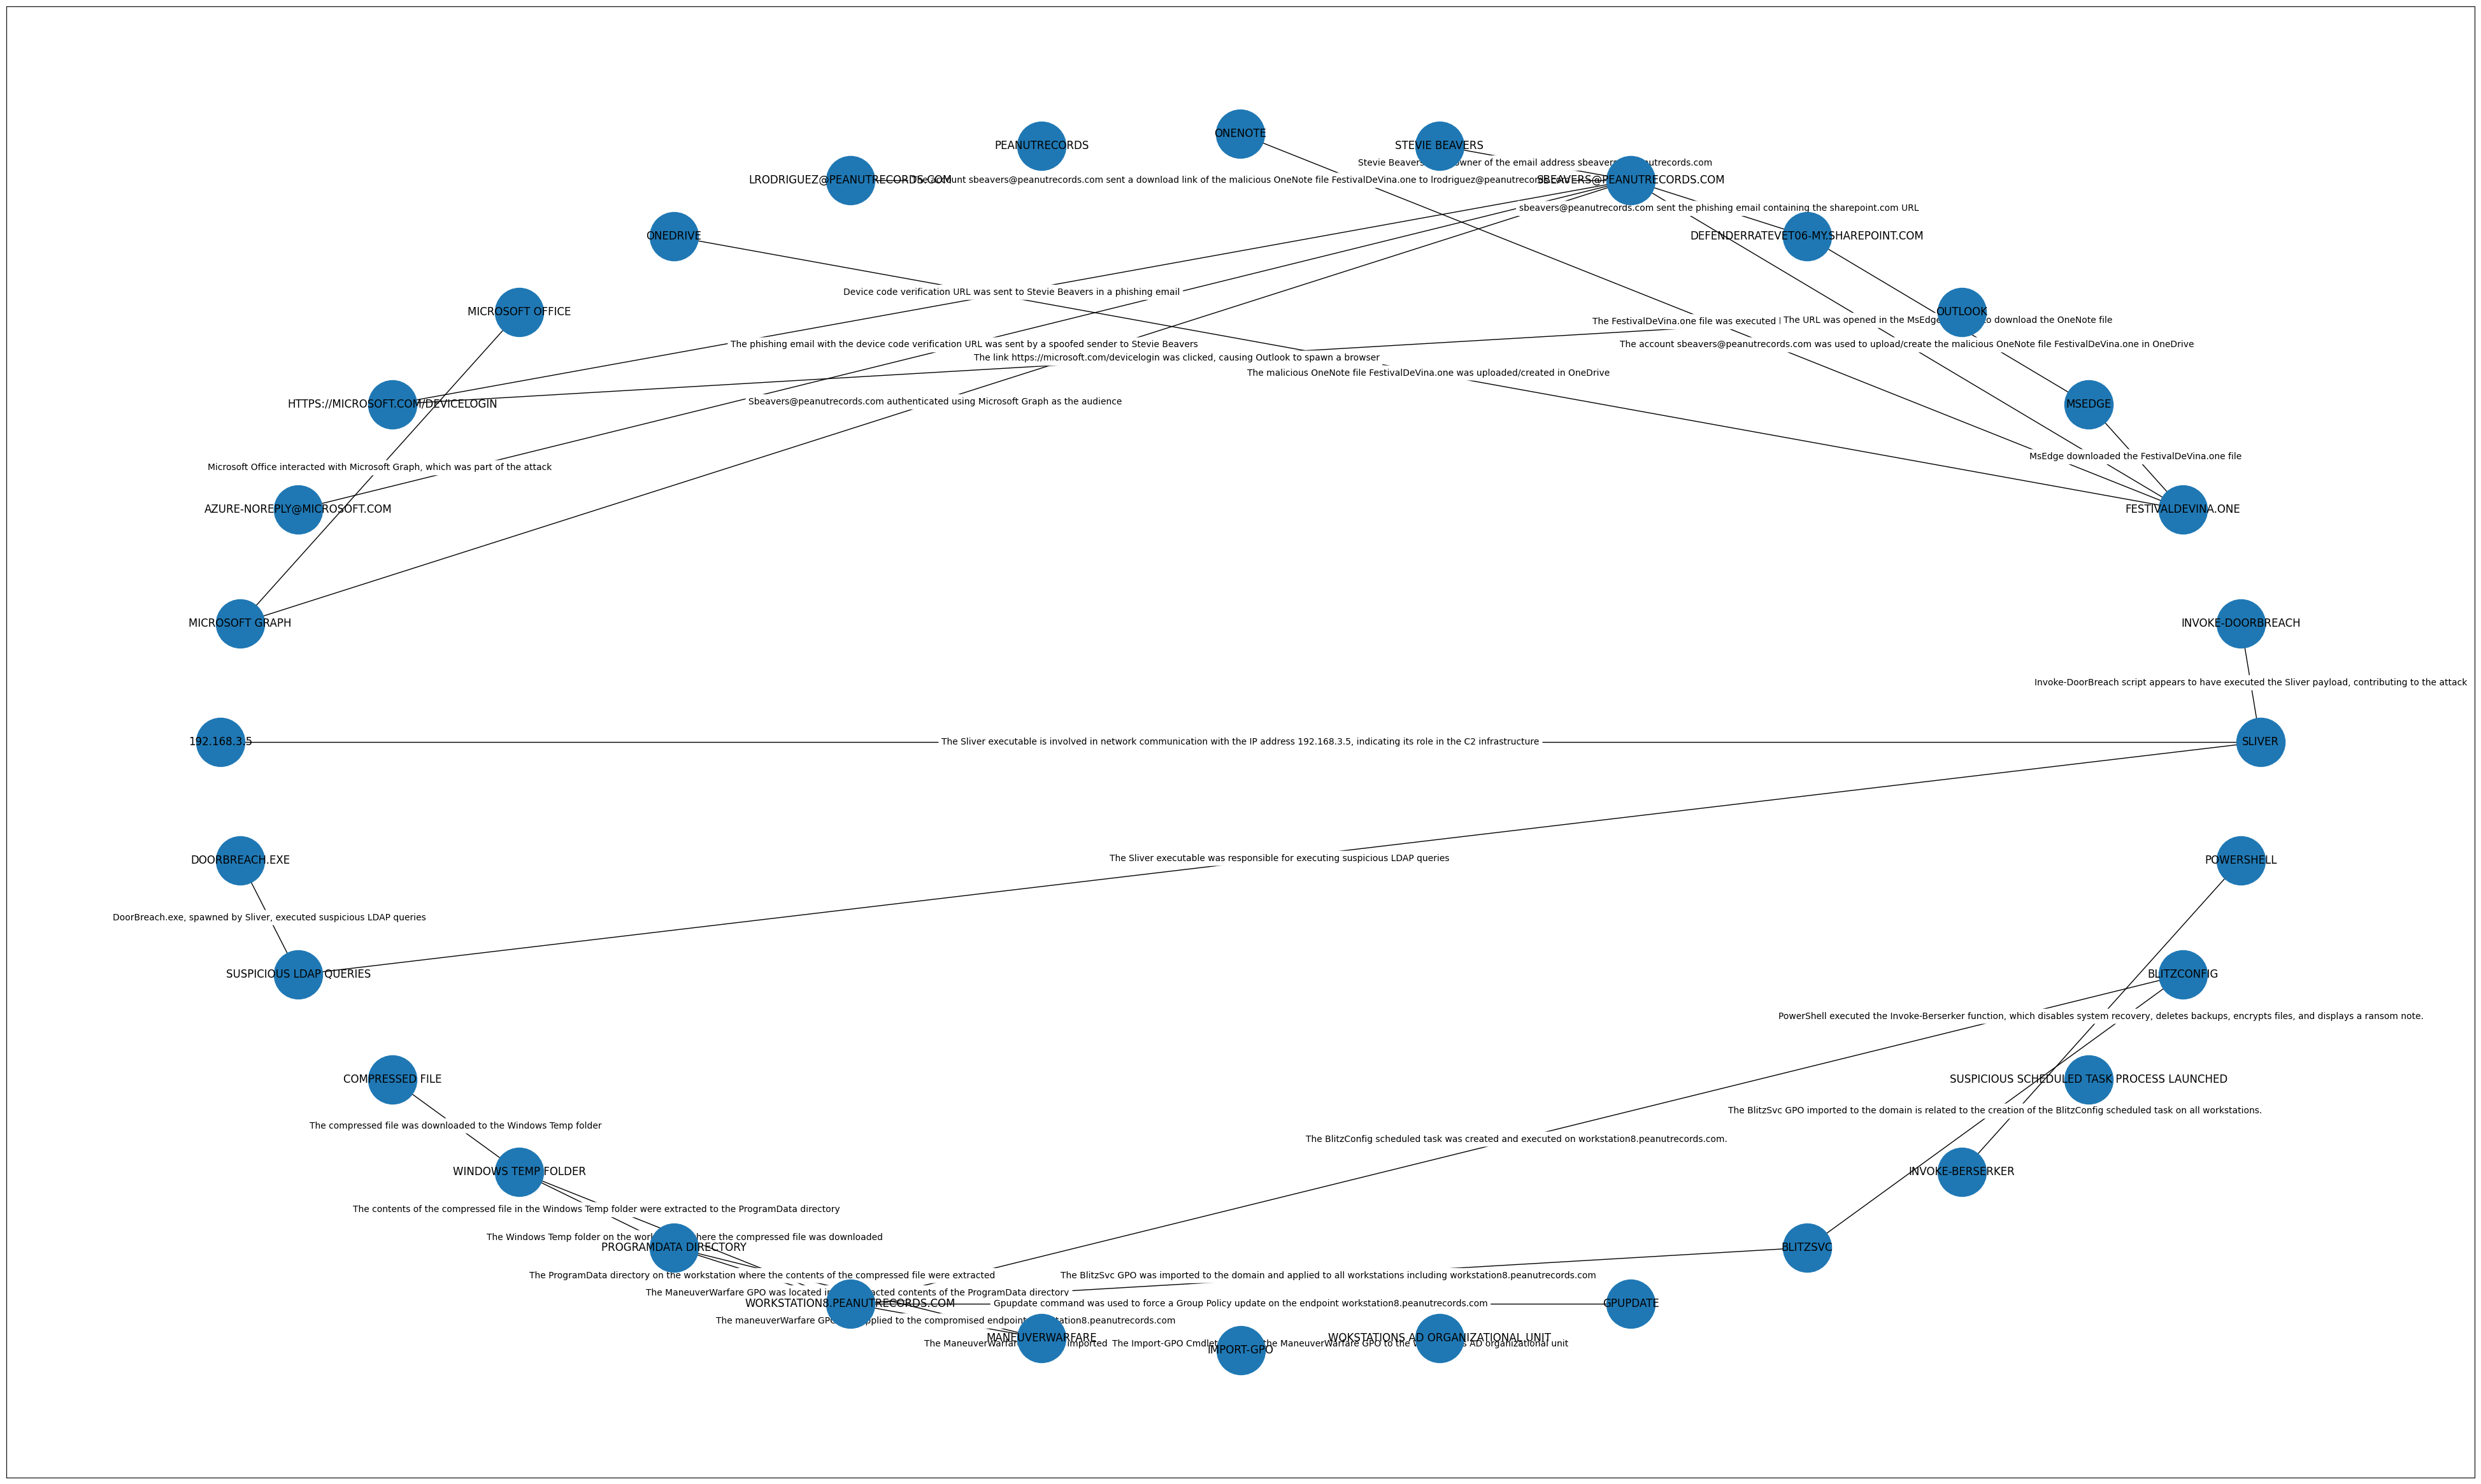

In [8]:

import networkx as nx
import matplotlib.pyplot as plt

def plot_graph_with_attributes(G, node_attr_name=None, edge_attr_name=None, node_label_offset=(0.12, 0.05), fig_size=(10, 7)):
    pos = nx.spring_layout(G, seed=0)
    pos = nx.circular_layout(G)
    
    # Get edge attributes if provided
    edge_labels = nx.get_edge_attributes(G, edge_attr_name) if edge_attr_name else {}
    
    # Get node attributes if provided
    node_states = nx.get_node_attributes(G, node_attr_name) if node_attr_name else {}
    
    # Set node state positions if node attributes exist
    state_pos = {n: (x + node_label_offset[0], y + node_label_offset[1]) for n, (x, y) in pos.items()} if node_attr_name else {}
    
    # Increase the figure size
    plt.figure(figsize=fig_size)
    
    # Draw graph
    nx.draw_networkx(G, pos, node_size=3000)
    
    # Draw node state labels if node attributes exist
    if node_attr_name:
        nx.draw_networkx_labels(G, state_pos, labels=node_states, font_color='red')
    
    # Draw edge attributes if edge attributes exist
    if edge_attr_name:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, rotate=False)
    
    # Show plot
    plt.show()

plot_graph_with_attributes(a.output, edge_attr_name="description", node_label_offset=(0.15, 0.1), fig_size=(50, 30))

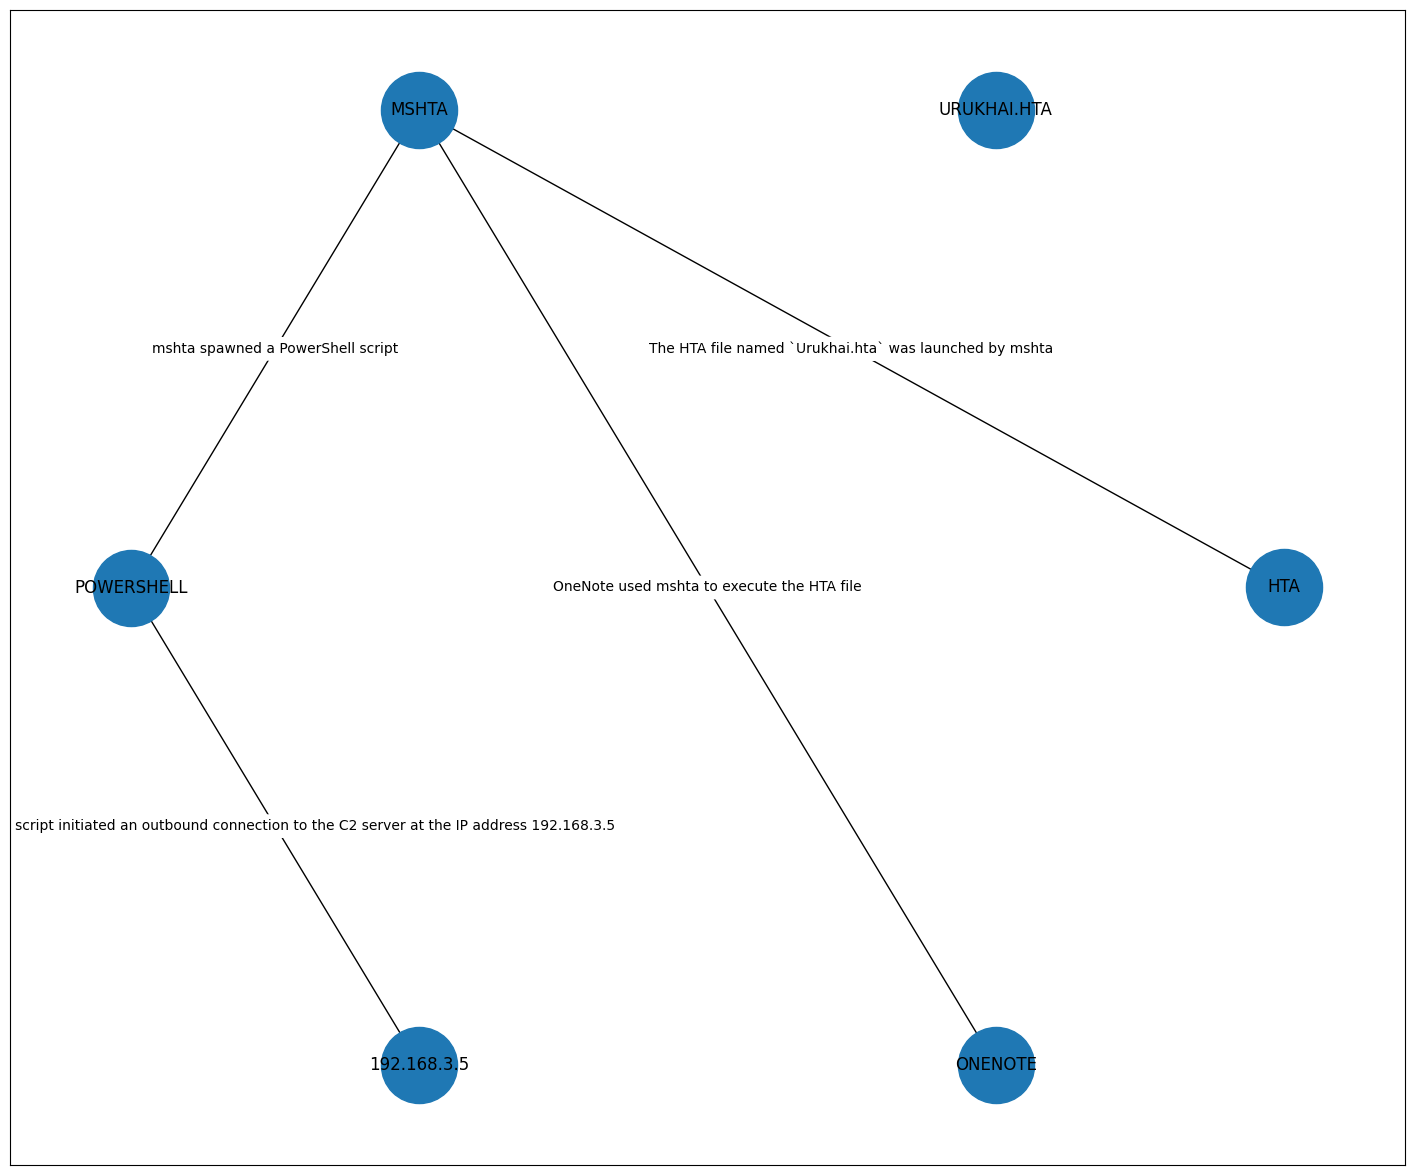

In [11]:

import networkx as nx
import matplotlib.pyplot as plt

def plot_graph_with_attributes(G, node_attr_name=None, edge_attr_name=None, node_label_offset=(0.12, 0.05), fig_size=(10, 7)):
    pos = nx.spring_layout(G, seed=0)
    pos = nx.circular_layout(G)
    
    # Get edge attributes if provided
    edge_labels = nx.get_edge_attributes(G, edge_attr_name) if edge_attr_name else {}
    
    # Get node attributes if provided
    node_states = nx.get_node_attributes(G, node_attr_name) if node_attr_name else {}
    
    # Set node state positions if node attributes exist
    state_pos = {n: (x + node_label_offset[0], y + node_label_offset[1]) for n, (x, y) in pos.items()} if node_attr_name else {}
    
    # Increase the figure size
    plt.figure(figsize=fig_size)
    
    # Draw graph
    nx.draw_networkx(G, pos, node_size=3000)
    
    # Draw node state labels if node attributes exist
    if node_attr_name:
        nx.draw_networkx_labels(G, state_pos, labels=node_states, font_color='red')
    
    # Draw edge attributes if edge attributes exist
    if edge_attr_name:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, rotate=False)
    
    # Show plot
    plt.show()

plot_graph_with_attributes(a.output, edge_attr_name="description", node_label_offset=(0.15, 0.1), fig_size=(18, 15))

In [41]:
import re

def remove_triple_backticks_blocks(text):
    """
    Remove all blocks of text enclosed within triple backticks from the input text.
    
    Args:
    text (str): The input text.
    
    Returns:
    str: The text with all triple backticks blocks removed.
    """
    pattern = re.compile(r'```.*?```', re.DOTALL)
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

# Example usage:
example_text = open("raw.txt").read()
cleaned_text = remove_triple_backticks_blocks(example_text)
print(cleaned_text)



### 02 - Initial Access

#### OneNote -> HTA File

One of the first alerts in this incident is related to a `OneNote` file executing some code. It seems to be potentially part of the threat actor's initial access tradecraft.

![](images/10-Investigation-InitialAccess-OneNote-Alert.png)

We can see that the `OneNote` document exported an HTA (HTML Application) file named `Urukhai.hta` which is then launched by `mshta` (Microsoft HTML Application Host).

![](images/11-Investigation-InitialAccess-OneNote-Mshta.png)

We can run the following KQL query to find `OneNote` executing `mshta` across all endpoints:



#### HTA File -> PowerShell

We can see a remote session being initiated in the context of `mshta`. We can also see `PowerShell` being spawned by `mshta`. The remote IP address is `192.168.3.5`. We know that IP address is what we used to set up our C2 so we can see the outbound connection.

![](images/12-Investigation-InitialAccess-Mshta-NetworkConnection.png)

We can see the `Powe

In [ ]:
Given an investigation report of an attack, please extract the key events and results from the events. Try to connect the events together.



############################
1. Event: OneNote.exe executes some OneNote file.
Result: This execution exported an HTA (HTML Application) file named `Urukhai.hta` which is then launched by `mshta` (Microsoft HTML Application Host).
2. Event: `mshta` (Microsoft HTML Application Host) launches `mshta` (Microsoft HTML Application Host).
Result:
- A remote connection is intiated, the remote IP address is `192.168.3.5`, which is used to set up the C2 connection.
- `PowerShell` is spawned by `mshta`, potentially downloading an additional script and executing it in memory.
3.